In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hlxon_hdf5io import *
from scipy.spatial.transform import Rotation
from metrics import *

# Load Data

In [2]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('NormalUDP2')


# get sensor data
araw = np.array(raw_9dof[:, :3])
gyro = np.array(raw_9dof[:, 3:6])
magn = np.array(raw_9dof[:, 6:])
ts = np.array(raw_timestamp)
raw_t = ts.reshape((-1, 1))
gt_t = np.array(gt_timestamp).reshape((-1, 1))

# Preprocess accelerations

In [3]:
# convenience
X, Y, Z = 0, 1, 2
N = len(raw_timestamp)

# rotate acceleration to global coords
accel = np.zeros_like(araw)
for i, orientation in enumerate(raw_rpy):
    
    # check if quat or euler
    if orientation.shape[-1] == 4:
        rot = Rotation.from_quat(orientation).inv()
    else:
        rot = Rotation.from_euler('xyz', orientation, degrees=True).inv()
    accel[i] = rot.apply(araw[i])

# Execute NDI dead-reckoning on the data

In [4]:
pos = np.zeros((N, 3))
vi = np.array([0., 0., 0.])
for i in range(1, N):
    dt = (ts[i]-ts[i-1])
    vi += accel[i]*dt
    pos[i] = pos[i-1] + vi*dt + 0.5*accel[i]*dt**2

# Evaluate ATE and RTE

In [5]:
timestamped_est = np.concatenate((raw_t , pos), axis=1)
timestamped_gt  = np.concatenate((gt_t, gt_position), axis=1)

ate, rte = compute_ate_rte(timestamped_est, timestamped_gt, 10)
print(f'Absolute Trajectory Error: {ate}\nRelative Trajectory Error: {rte}')

Absolute Trajectory Error: 4342193141544594.5
Relative Trajectory Error: 21513483974693.477


# Plot Results

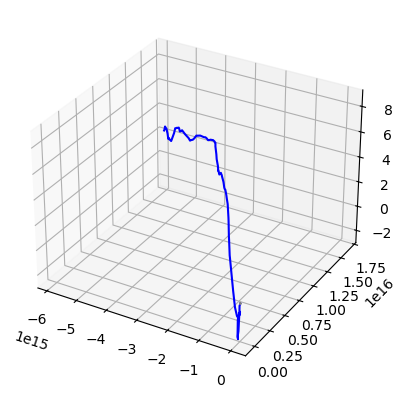

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pos[:, 0], pos[:, 1], pos[:, 2], 'blue')
ax.plot3D(gt_position[:, 0], gt_position[:, 1], gt_position[:, 2], 'gray')
plt.show()